# Yearly Maxima Return Level Estimation: Example 4

In this notebook, we proceed to the step by step anylsis for the estimation of the 10-year return level of groundwater level using statistical analysis. 

Example 4 described the more complex cases where multiple advanced tools, such as trend estimation and increased block sizes, are necessary to obtain accurate estimates.

We start by loading all the libraries necessary to perform the analysis.

In [1]:
# Load necessary libraries

# Library for easy date manipulation
library(lubridate) 

#Library for estimation of parametric models using l-moment matching
library(lmom)

#Library for estimation of parametric EVT models using maximum likelihood
library(evd)

# Library for automatic trend estimation
library(mgcv)

# Library for data manipulation
library(dplyr)

# Libraries for data plotting
library(ggplot2)
library(repr)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




We now load and format the data into the R environment. We prepare a data.frame object including the following columns:
* Zeitstempel (date object): date (and time if available) of the measurement,
* Wert (numeric): measured grouddwater level,
* Jahre (categorical): Year of the measurement used to later compute yearly maxima,
* Zeitstempel_seit_ersten_wert (numeric): numerical time since the beginnin of the measures.

In [2]:
# Read and import data from csv file
data <- read.csv("../data/data_groundwater_level_4.csv", header = TRUE, sep = ",")

# Converte date string into date object
data$Zeitstempel <- ymd(data$Zeitstempel)

# Create column with year
data$Jahre <- (year(data$Zeitstempel))

#Create column with numerical time
data$Zeitstempel_seit_ersten_wert <- as.numeric(data$Zeitstempel) - as.numeric(data$Zeitstempel[1]) 

# Display first 6 rows of the data 
head(data)

,Zeitstempel,Wert,Jahre,Zeitstempel_seit_ersten_wert
,<date>,<dbl>,<dbl>,<dbl>
1,1977-01-01,426.78,1977,0
2,1977-01-02,426.78,1977,1
3,1977-01-03,426.78,1977,2
4,1977-01-04,426.78,1977,3
5,1977-01-05,426.78,1977,4
6,1977-01-06,426.78,1977,5


We now create another dataframe that contains the yearly maxima.

In [3]:
data_yearly_maxima <- data %>% group_by(Jahre) %>% summarize(Max = max(Wert, na.rm = TRUE), Date_maxima = Zeitstempel[which.max(Wert)])
head(data_yearly_maxima)

Jahre,Max,Date_maxima
<dbl>,<dbl>,<date>
1977,429.98,1977-06-20
1978,431.43,1978-05-02
1979,430.64,1979-05-02
1980,431.56,1980-03-15
1981,431.99,1981-12-31
1982,432.97,1982-02-16


It is now possible to plot the time series of measuresment along with the corresponding maxima.

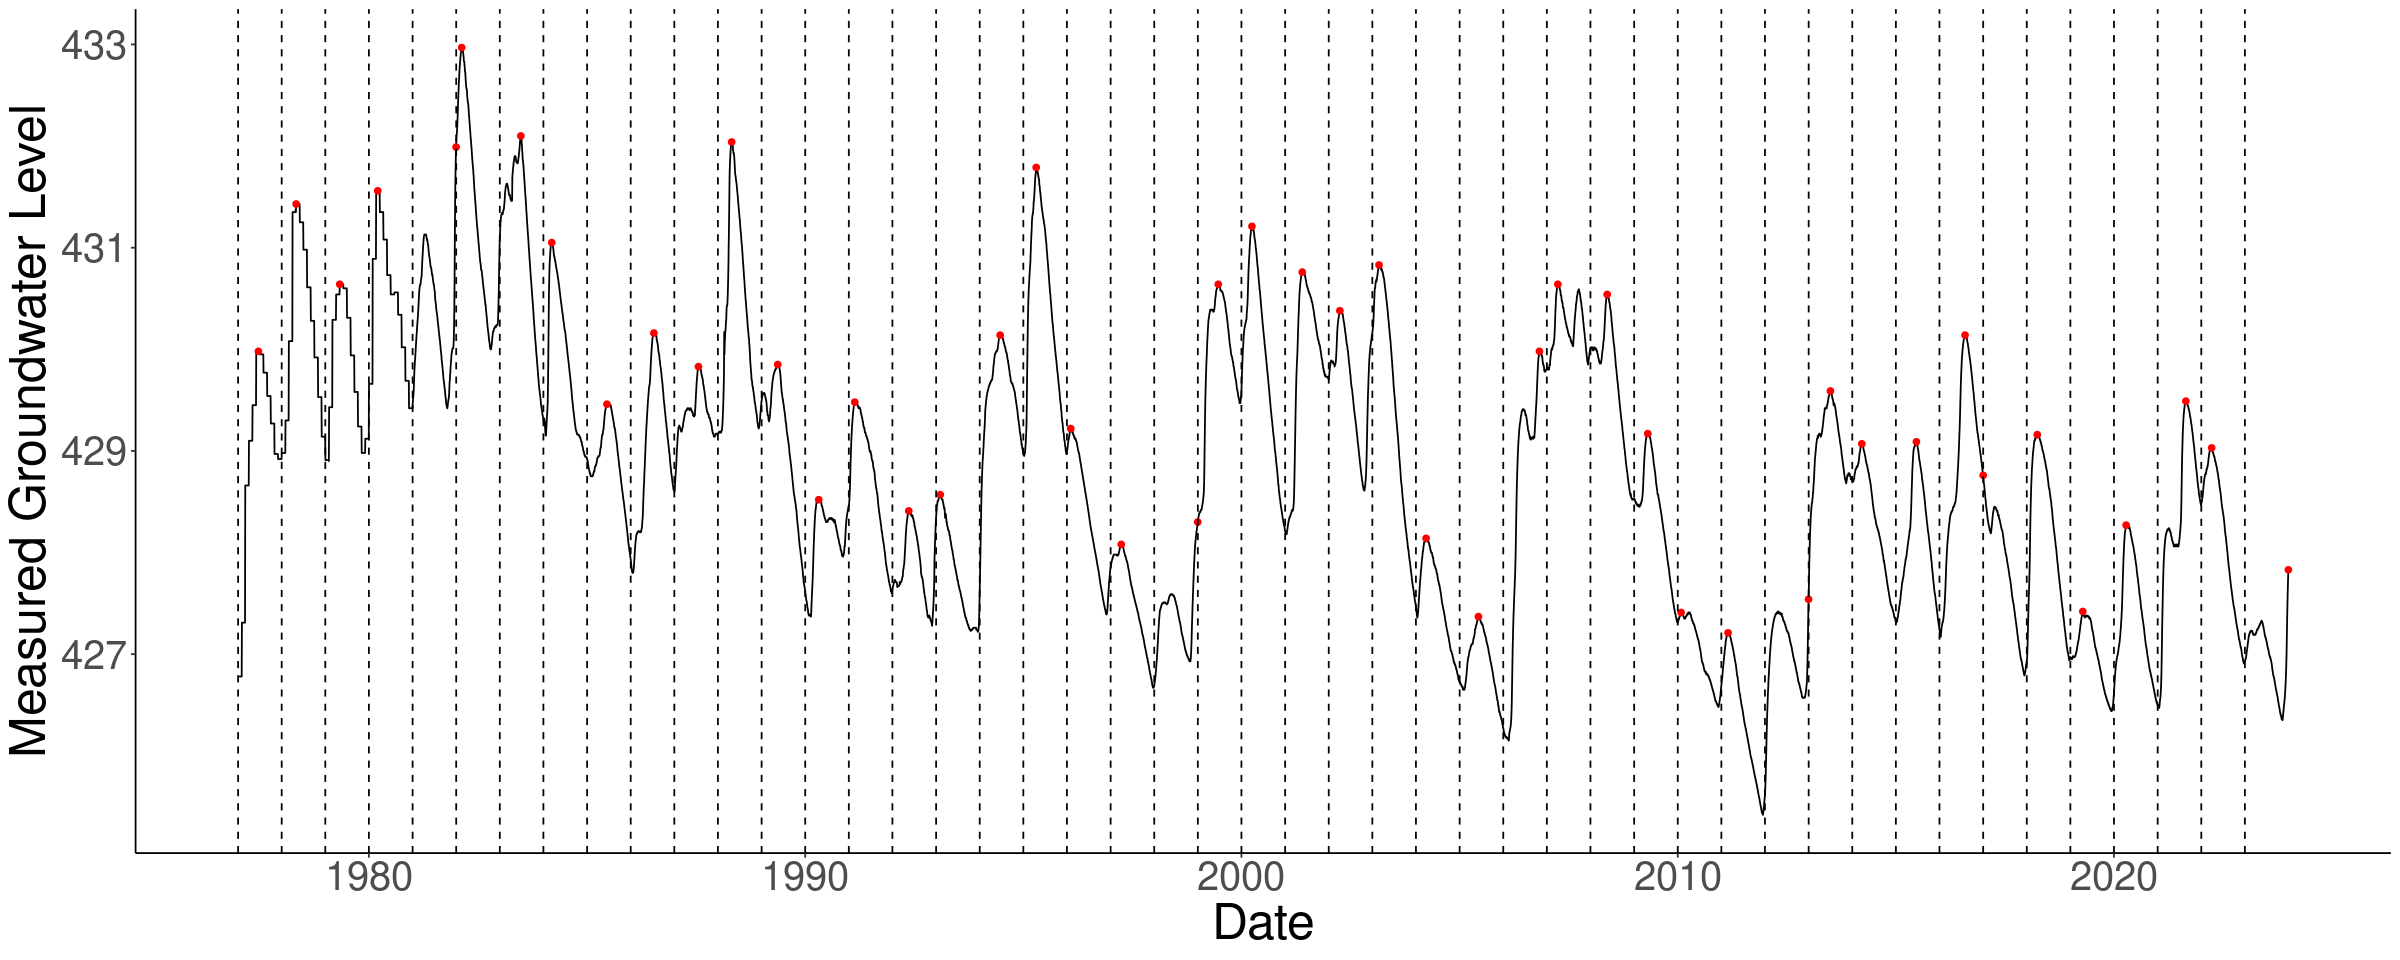

In [4]:
# Increase the plot size
options(repr.plot.width=20, repr.plot.height=8)

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Measured Groundwater Level")

We observe that the time series is not stationatry and that there is a decreasing trend over the years. In oder to satistify to the "identically distributed" assumption necessary to apply statistical anylsis, we will first estimate and remove the trend in the data.

## Trend estimation and removal

Trend estimation and removal, could be applied either on the original measurements or directly on the yearly maxima. However, the quantity of information is much greater using the original data which facilitates the astimation of the trend.

In practice, trand estimation is done using a Generalized Additive Model (GAM) estimated thanks to the package `mgcv`.

In [5]:
#Trend estimation using a GAM
library(mgcv)

# Estimate the parameters of the GAM
gam_trend_estimation <- gam(Wert~s(Zeitstempel_seit_ersten_wert), data = data)

# Compute the trend for each date
data$trend <- predict(gam_trend_estimation, data, type = 'response', se.fit = FALSE)

#Remove trend from original data
data$Wert_standardized <- data$Wert - data$trend

We now first plot the original data with the trend.

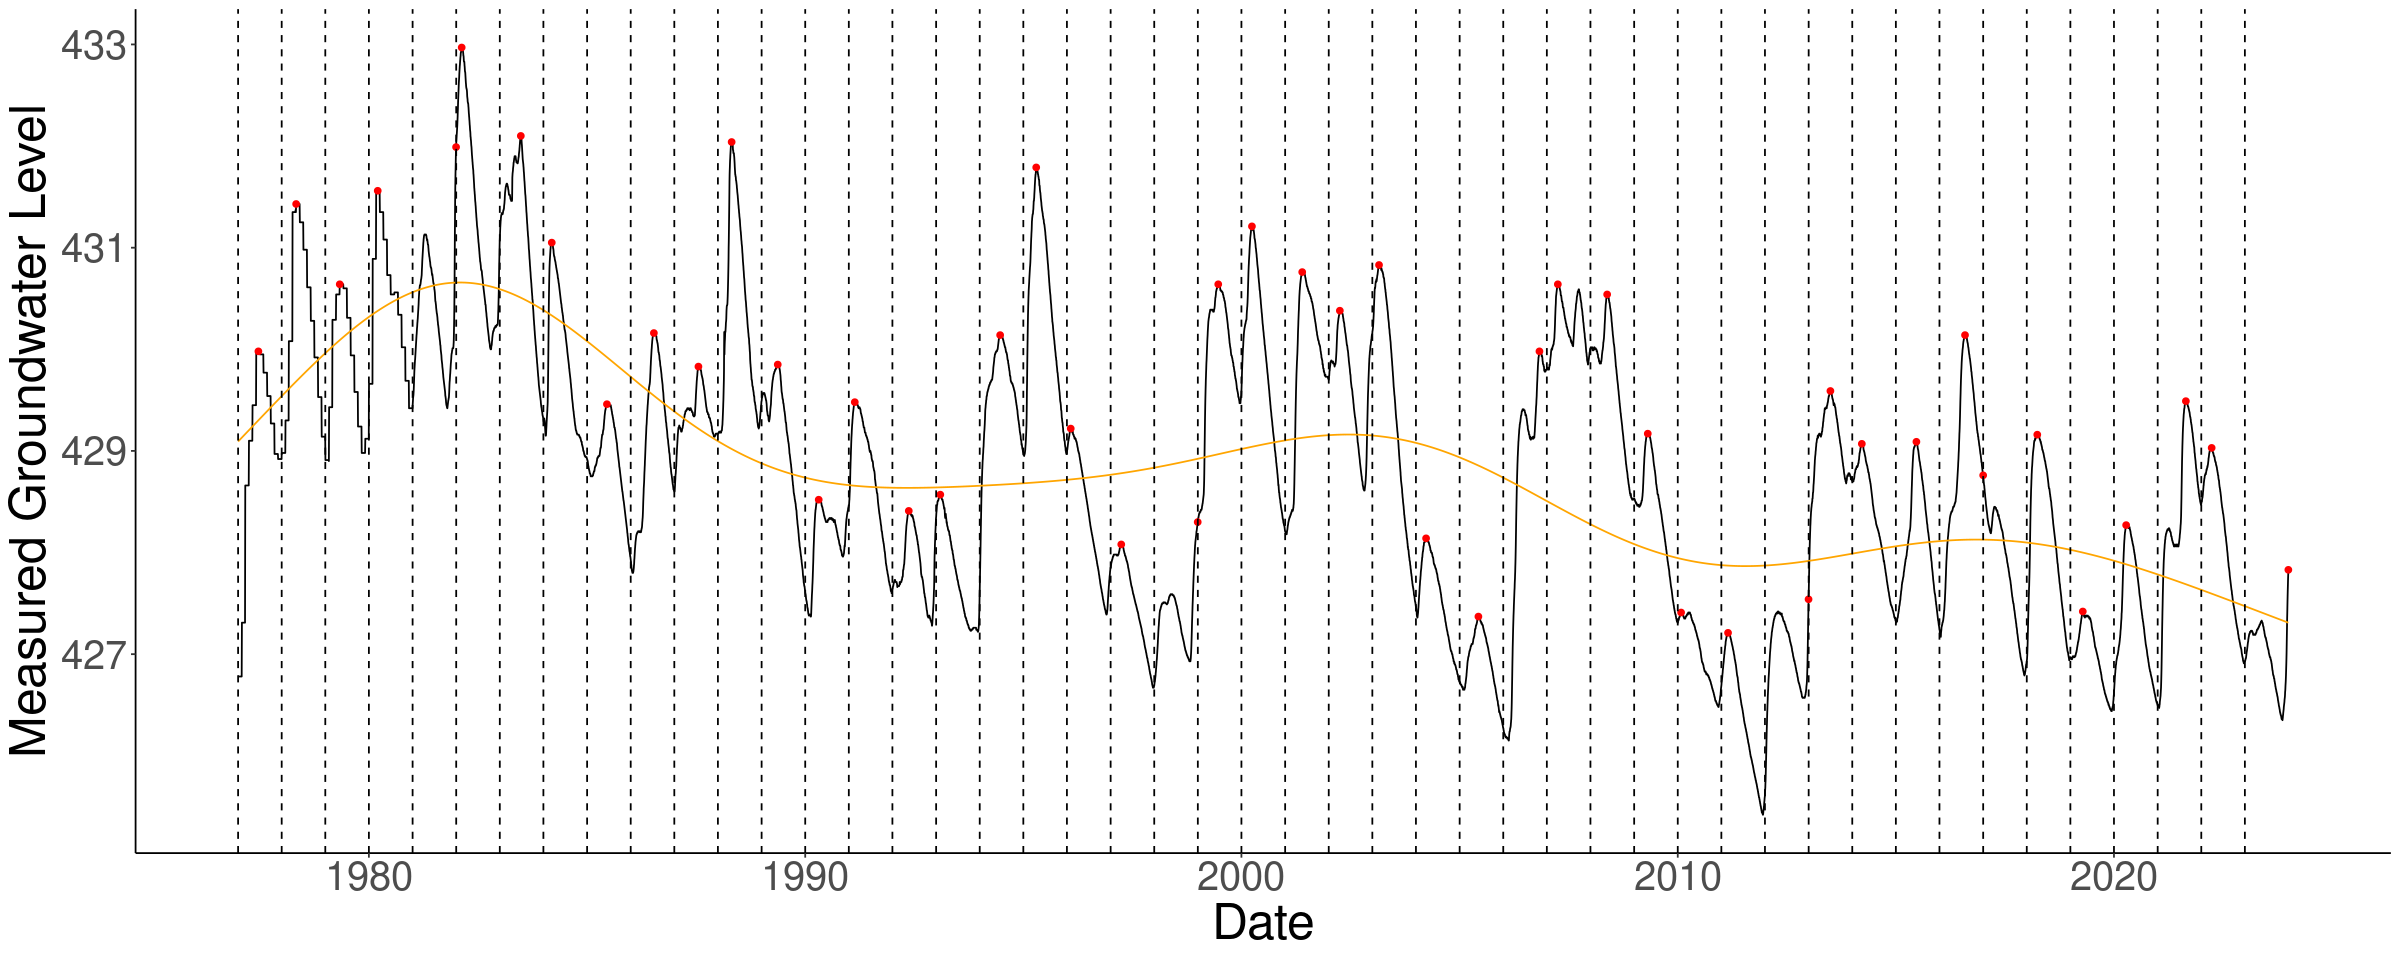

In [6]:
# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
     geom_line(data = data, aes(x = Zeitstempel, y = trend), color = "orange") + #add trend line
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Measured Groundwater Level")

We can also plot the standardized time series, i.e., the data whose trend have been removed, to vizually check that the new time series is now stationary in time.

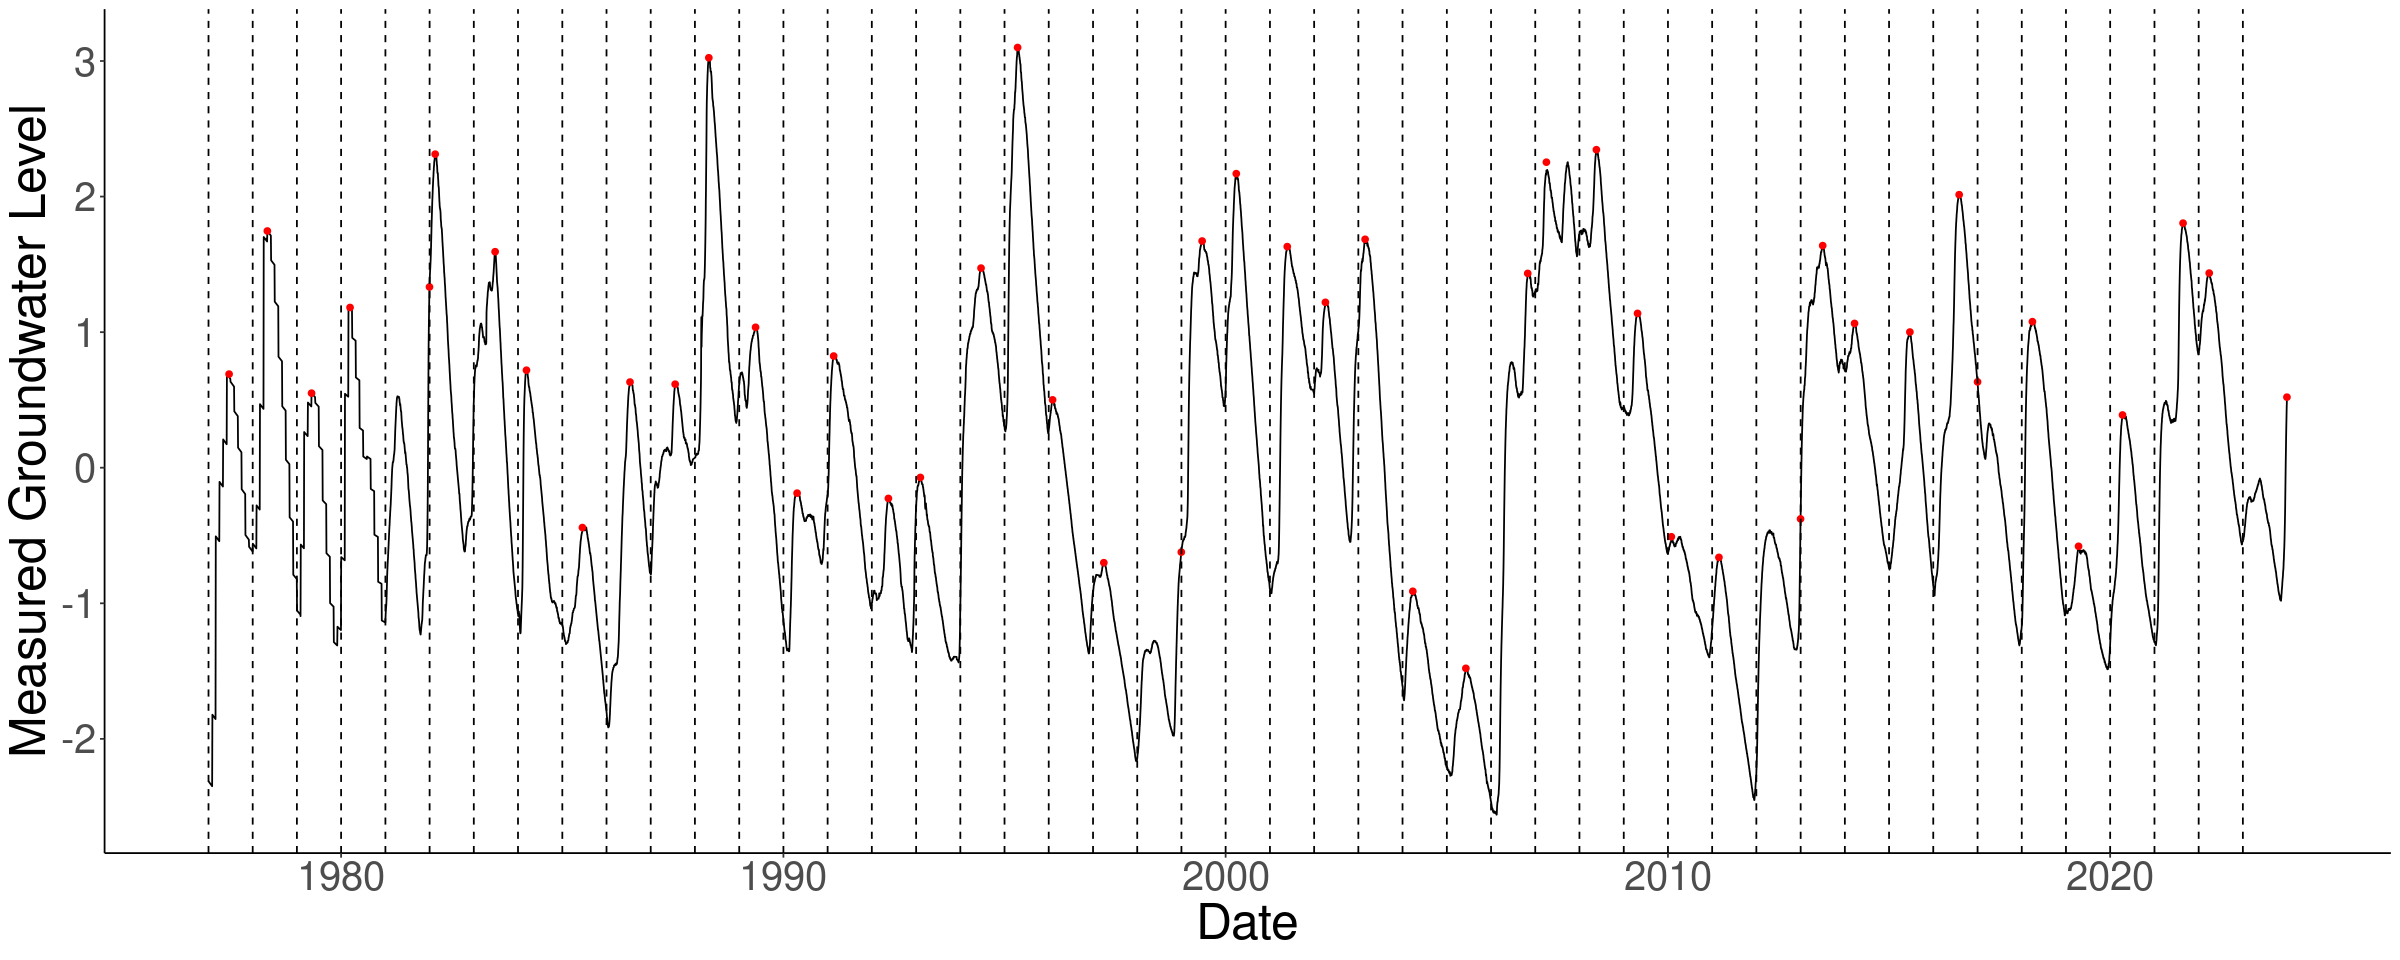

In [7]:
# We compute the yearly maxima of both the standardized and non-standardize data
data_yearly_maxima <- data %>%
                        group_by(Jahre) %>%
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Max_standardized = max(Wert_standardized, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)])

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert_standardized)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max_standardized), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Measured Groundwater Level")

Now that the trend has been removed, we can move to the next, i.e., checking that the yearly maxima measurements are independent.

## Checking the independence of yearly maxima measurement

Independence of yearly maxima wil be checked thanks to the computation of an auto-correlation function: we compute the correlation between a measurement at year `y` and a measurement at year `y + t`. The empirical estimate of the function can be computed automatically using the function `acf`.

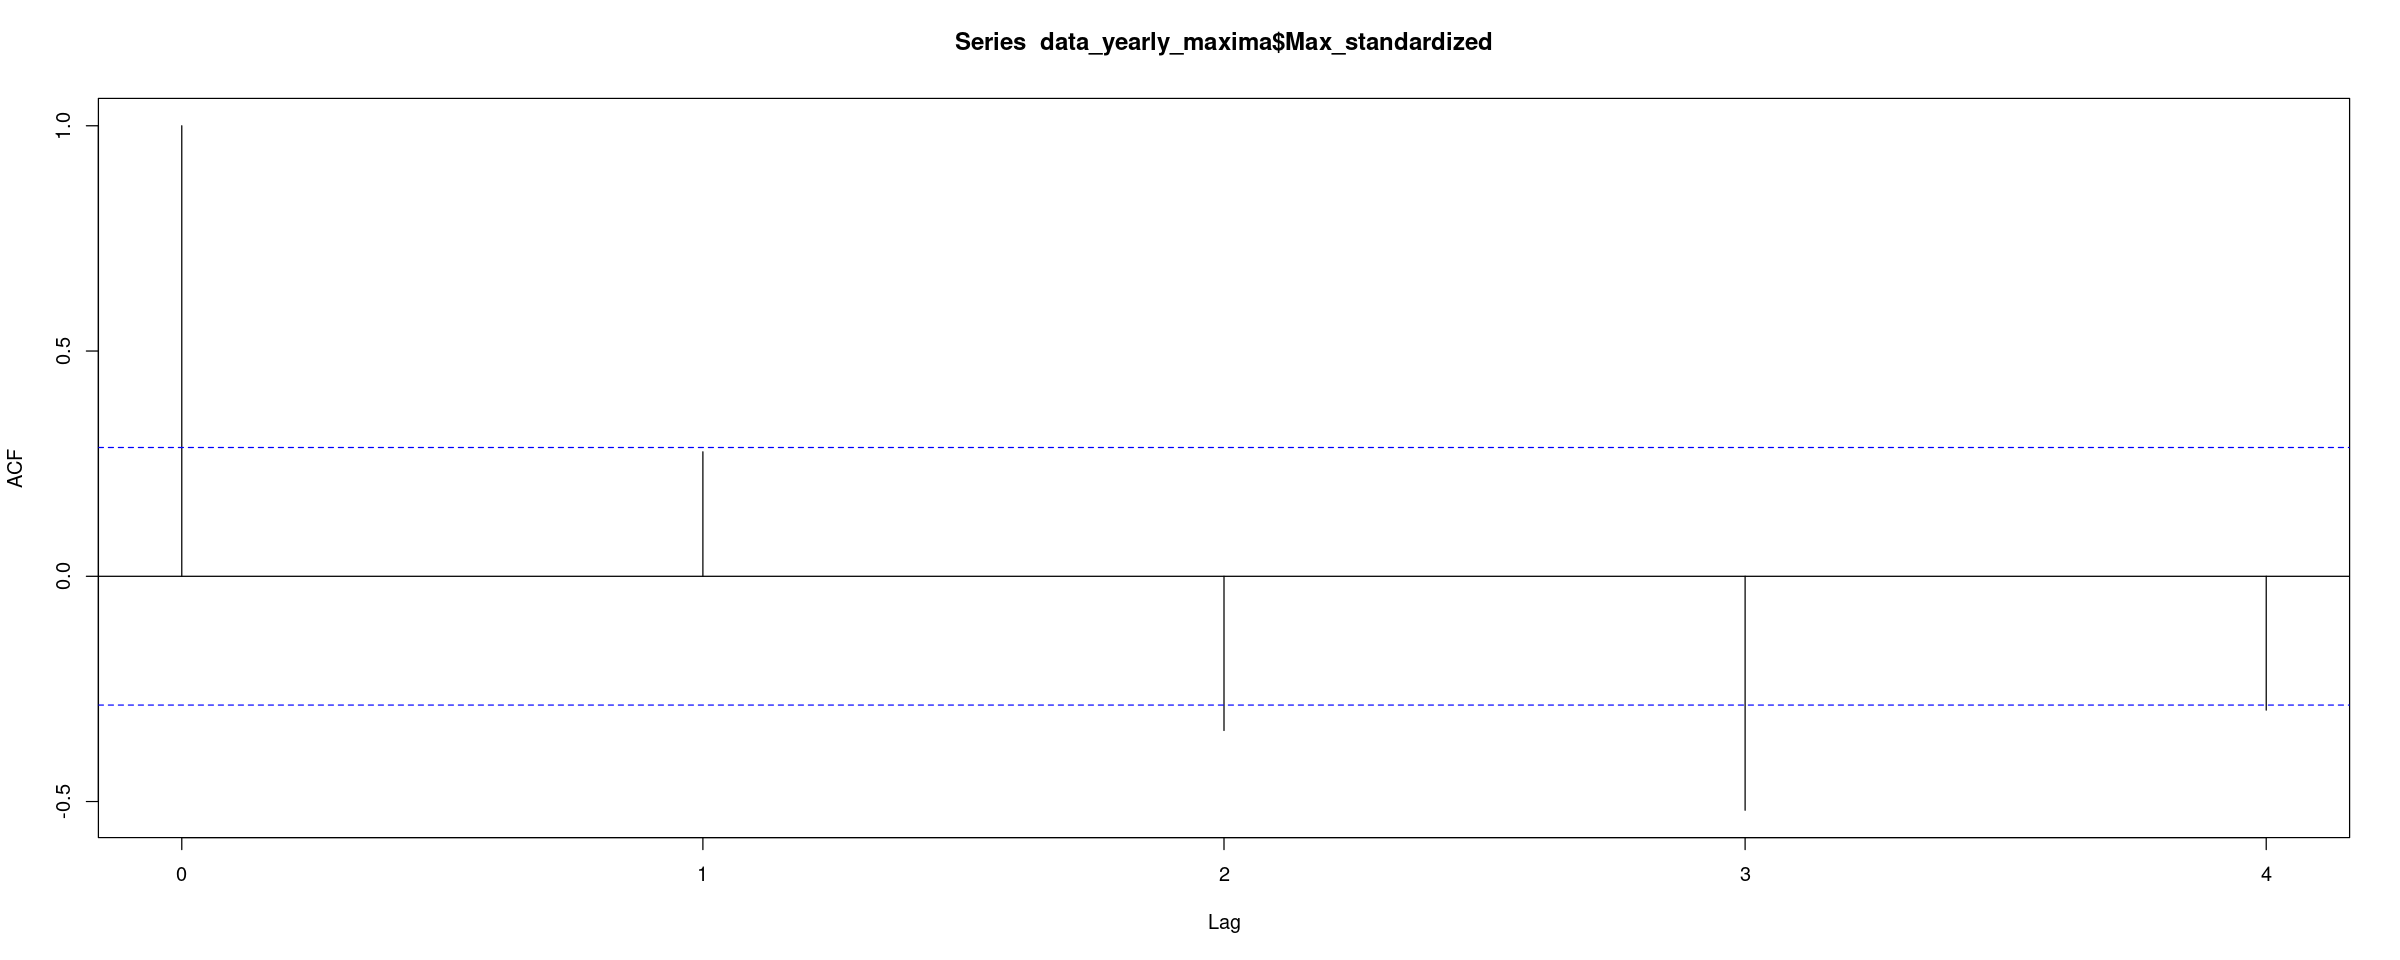

In [8]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima$Max_standardized, lag = 4, na.action = na.pass)

Correlation at lag `0`correspond to the variance of the yearly maxima. We obserbe that for lags `t = 2,3` the correletaion exceeds the dashed blue line, meaning that there is  evidence that there is a residual  correlation between yearly maxima.

As we failed to fully remove dependence thanks to the trend removal step, we will attempt to decrease dependence by increasing the block size to 2 years.

An alternative could also be to compute block maxima over blocks of days starting at other dates than January 1st. The latter would be relevant if we abserve many multiple pairs of maxima belonging to the same "peak". This is however not the case in this example so we will favour the larger block size solution.

In [9]:
#Initialize the first row of new data-frame
data_yearly_maxima_largerblock <- data_yearly_maxima[1,]

# Define new block size (number of years)
block_size <- 2

#Compute the maxima of the new larger blocks
for(i in 1:floor(dim(data_yearly_maxima)[1] / block_size)){
    indexes <- (block_size) * (i - 1) + 1:block_size
    pos <- which.max(data_yearly_maxima$Max_standardized[indexes])
    data_yearly_maxima_largerblock[i,] <- data_yearly_maxima[indexes[pos],]
    data_yearly_maxima_largerblock[i,1] <- min(data_yearly_maxima$Jahre[indexes])
}

# Display the first 6 rows
head(data_yearly_maxima_largerblock)

Jahre,Max,Max_standardized,Date_maxima
<dbl>,<dbl>,<dbl>,<date>
1977,431.43,1.7461657,1978-05-02
1979,431.56,1.1819516,1980-03-15
1981,432.97,2.3129213,1982-02-16
1983,432.10,1.5932971,1983-06-26
1985,430.16,0.6321081,1986-07-14
1987,432.04,3.0239007,1988-04-25


We now check that with the new block size, the maxima measurements are independent by computing the autocorrelation fuction.

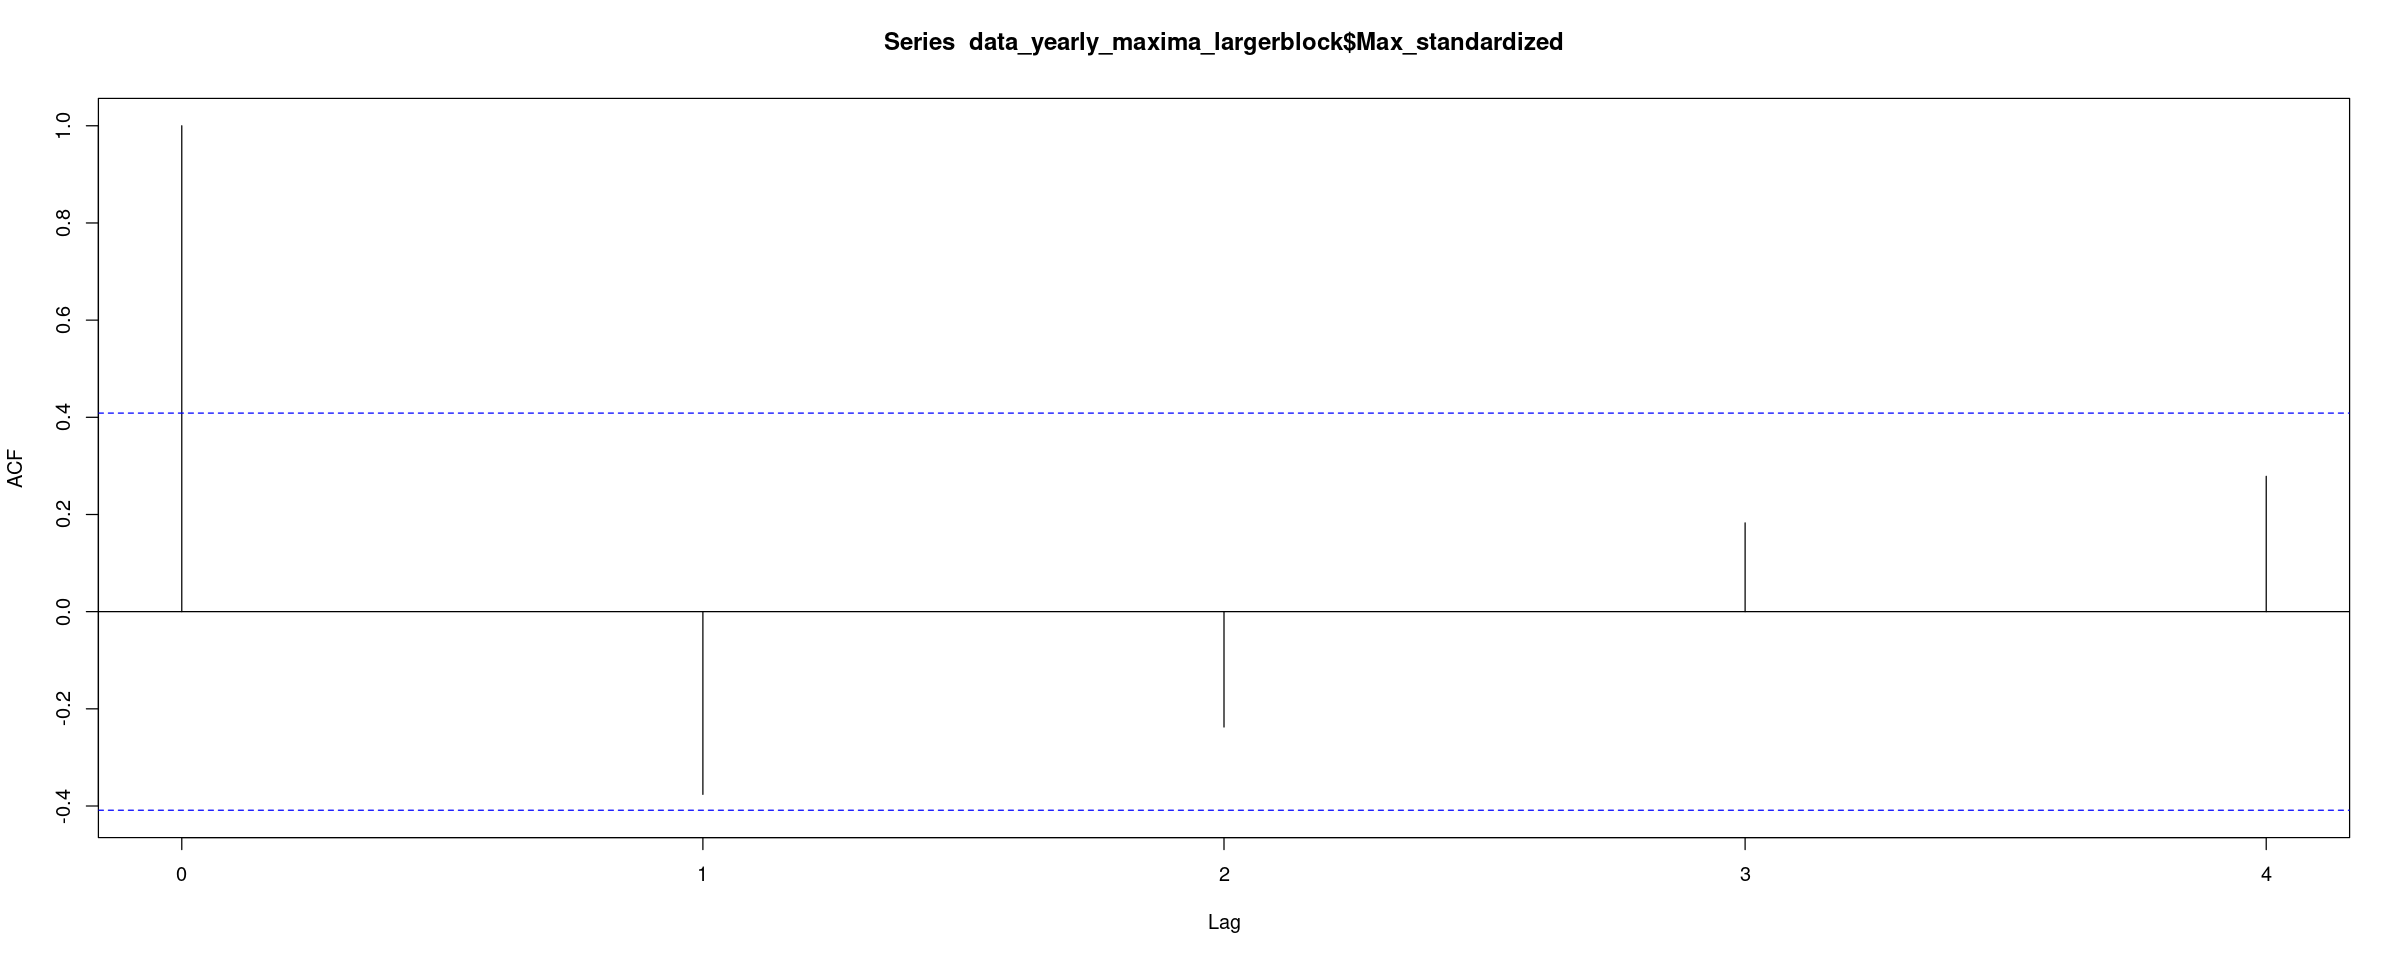

In [10]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima_largerblock$Max_standardized, lag = 4, na.action = na.pass)

We now observe that the empirical correlation does not exceed the dashed blue line for any lag greater that `t > 0`. We can conclude that measurements are now independent and that we can now move to the next step, i.e., model estilation and selection.

## Model estimation and selection

We now use the independent block maxima observations to estimate and select a paramteric model. As we have less than `100` observations, we will prefer L-moment estimation matching over maximum likelihood as the former is know to provide more robust estimates for small sample sizes.

We consider two models:
* Generalized Extreme Value (GEV) distribution: the model is theoretically motivated as it appears as a natural asymptotic distribution for the distribution of block maxima of increasing size,
* Log-Pearson III: this model is extremely popular in hydrology, with an equivalent number of parameters than the GEV, and is sometime found to be a better fit to the data.
* Weibull distribution: the Weibull model is on specific case of GEV when the associated random variable is bounded from above. We observe empirically that groundwater level usually falls into this category. Estimating directly a Weibull distribution instead of a GEV sometime provides a better fit to the data when the added constraint that there is an upper bound to the data is realistic.

We thus use the package `lmom` to estimate the parameters the three distribution above.

In [11]:
#Comput l-moments of the observations
lmom <- samlmu(data_yearly_maxima_largerblock$Max_standardized)
lmom

#Estimate GEV parameters
gev <- pelgev(lmom)

#Estimate log-Pearsonn III parameters
pIII <- pelpe3(lmom)

# Compute Weibull parameters
wei <- pelwei(lmom)

print("GEV Parameters:")
gev
print("Weibull Parameters:")
wei
print("Log-Pearson III:")
pIII

l_1         l_2         t_3         t_4 
 1.44555741  0.51163514 -0.08022484  0.22706283

[1] "GEV Parameters:"


xi     alpha         k 
1.1917473 0.9645732 0.4334453

[1] "Weibull Parameters:"


zeta      beta     delta 
-3.915015  5.734421  6.909968

[1] "Log-Pearson III:"


mu      sigma      gamma 
 1.4455574  0.9137096 -0.4911112

We now have estimates for all parameters of the three candidate models. We will select the best fitting one by computing their respective negative-log likelihood and choosing the one with the lowest value.

In [12]:
print("Neg-log likelihood:")
(paste0("GEV: ",-sum(log(evd::dgev(data_yearly_maxima_largerblock$Max_standardized, loc = gev[1], scale = gev[2], shape = -gev[3])))))
(paste0("Weibull: ",-sum(log(dweibull(data_yearly_maxima_largerblock$Max_standardized - wei[1],scale = wei[2], shape = wei[3])))))
(paste0("Pearson3: ",-sum(log(dgamma(abs(data_yearly_maxima_largerblock$Max_standardized - (pIII[1] - 2 *  pIII[2] /  pIII[3])), shape = 4/(pIII[3])^2, scale =  pIII[2] * abs(pIII[3]) / 2)))))

[1] "Neg-log likelihood:"


[1] "GEV: 29.7199317607153"

[1] "Weibull: 29.6983091400331"

[1] "Pearson3: 29.7073593063127"

We observe that the model with minimal negative log-likelihood is the Weibull distribution that we choose for to estimate the 10-year return level of the yearly maxima.

## 10-year return level estimation

We will now compute the resturn level function for the selected model. To do so, we will use a paramteric boostrap method, i.e., a form a Monte Carlo sampling, that allow to quantify the uncertainty of the estimated return levels.

In [191]:
source("utils.r")

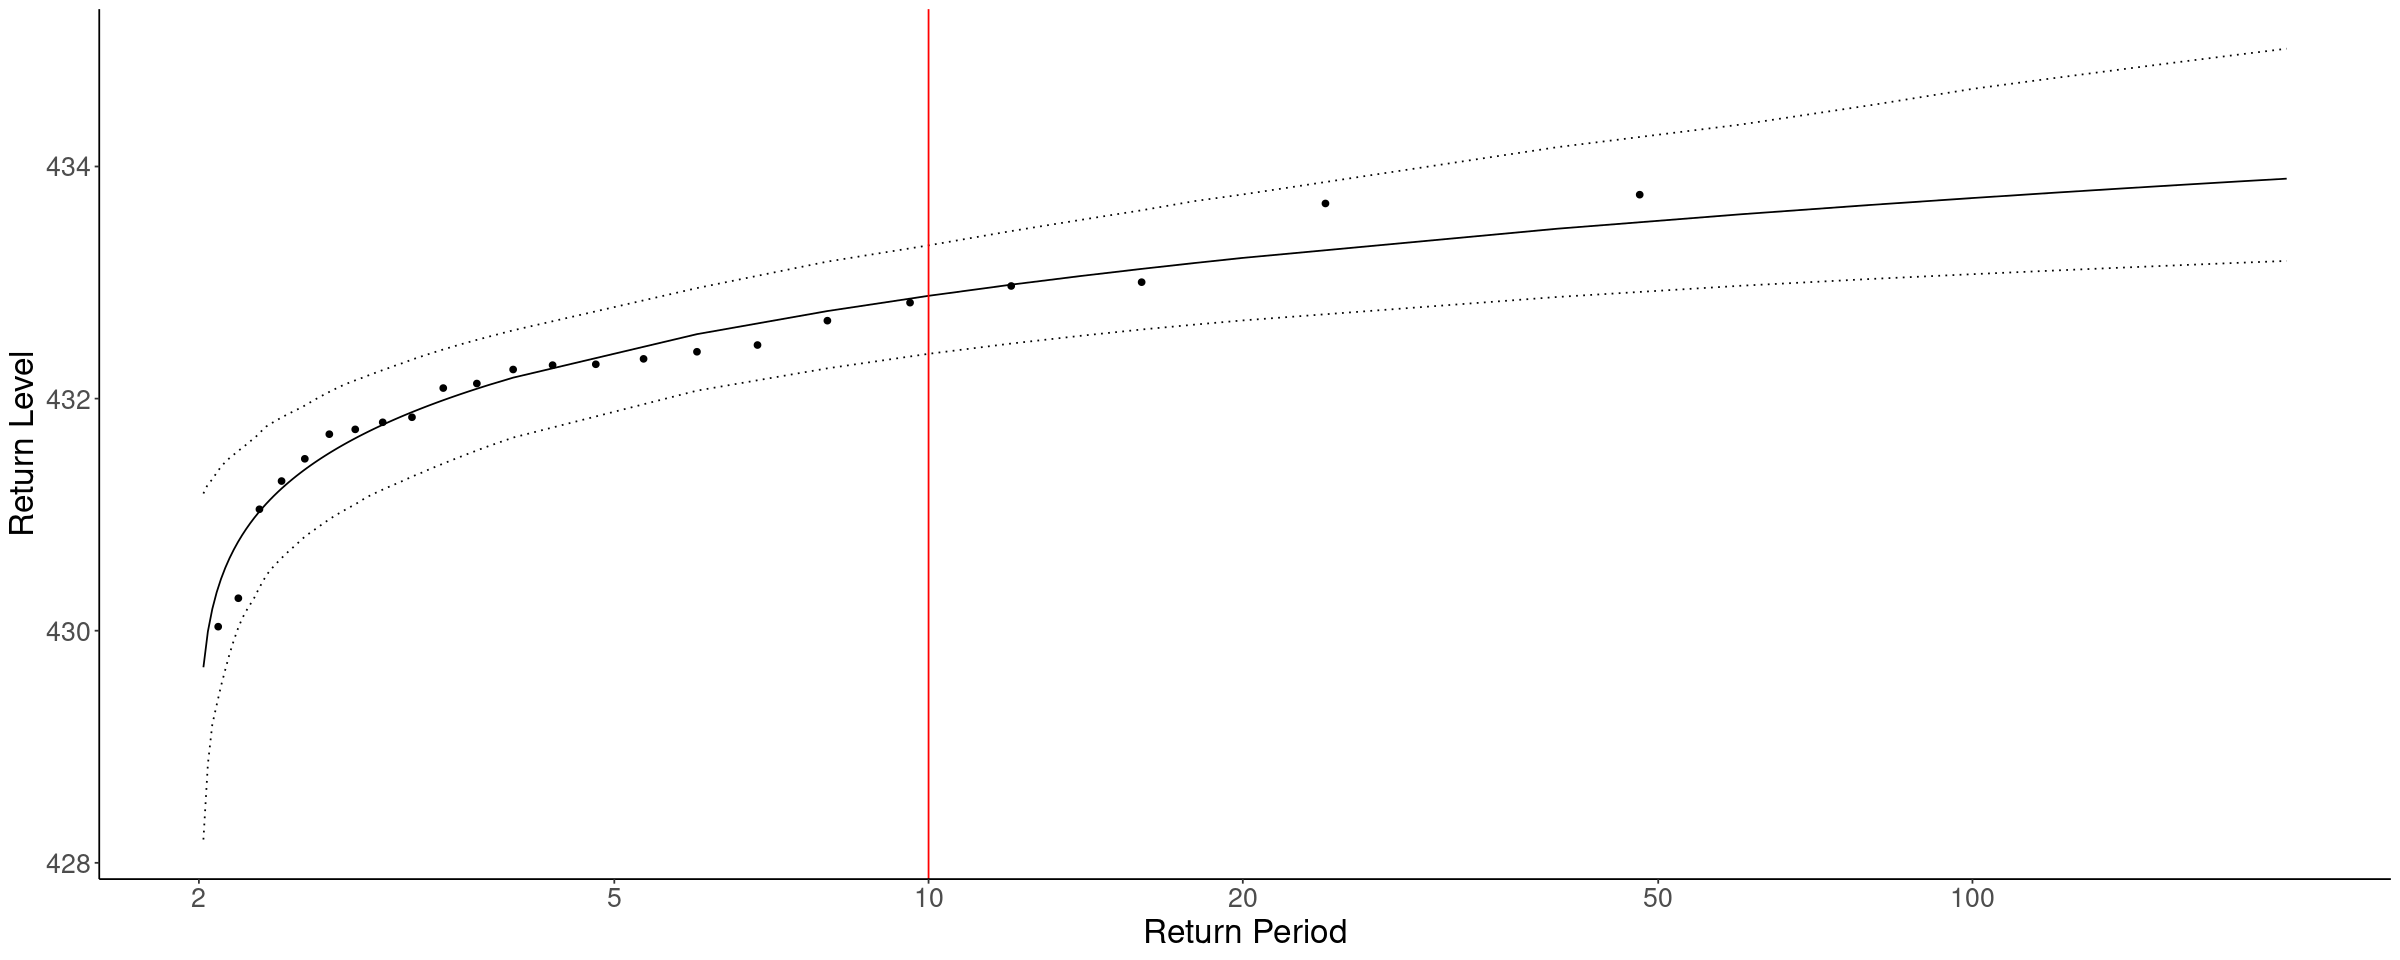

In [202]:
display_return_level_function(data = data_yearly_maxima_largerblock, parameters = wei, max_trend = max(data$trend))

In [201]:
return_levels <- compute_return_level(return_period = 10, parameters = wei, n_obs = length(data_yearly_maxima_largerblock$Jahre), max_trend = max(data$trend))
return_levels

[1] "Weibull"
[1] 108   3
[1] 94
integer(0)


,Return_period,Return_level,Lower_CI_bound,Upper_CI_bound
,<dbl>,<dbl>,<dbl>,<dbl>
zeta,10,432.8856,NaN,NaN


We observe that all observed values lies within the uncertainty bound: the estimated model is consistent with observations.

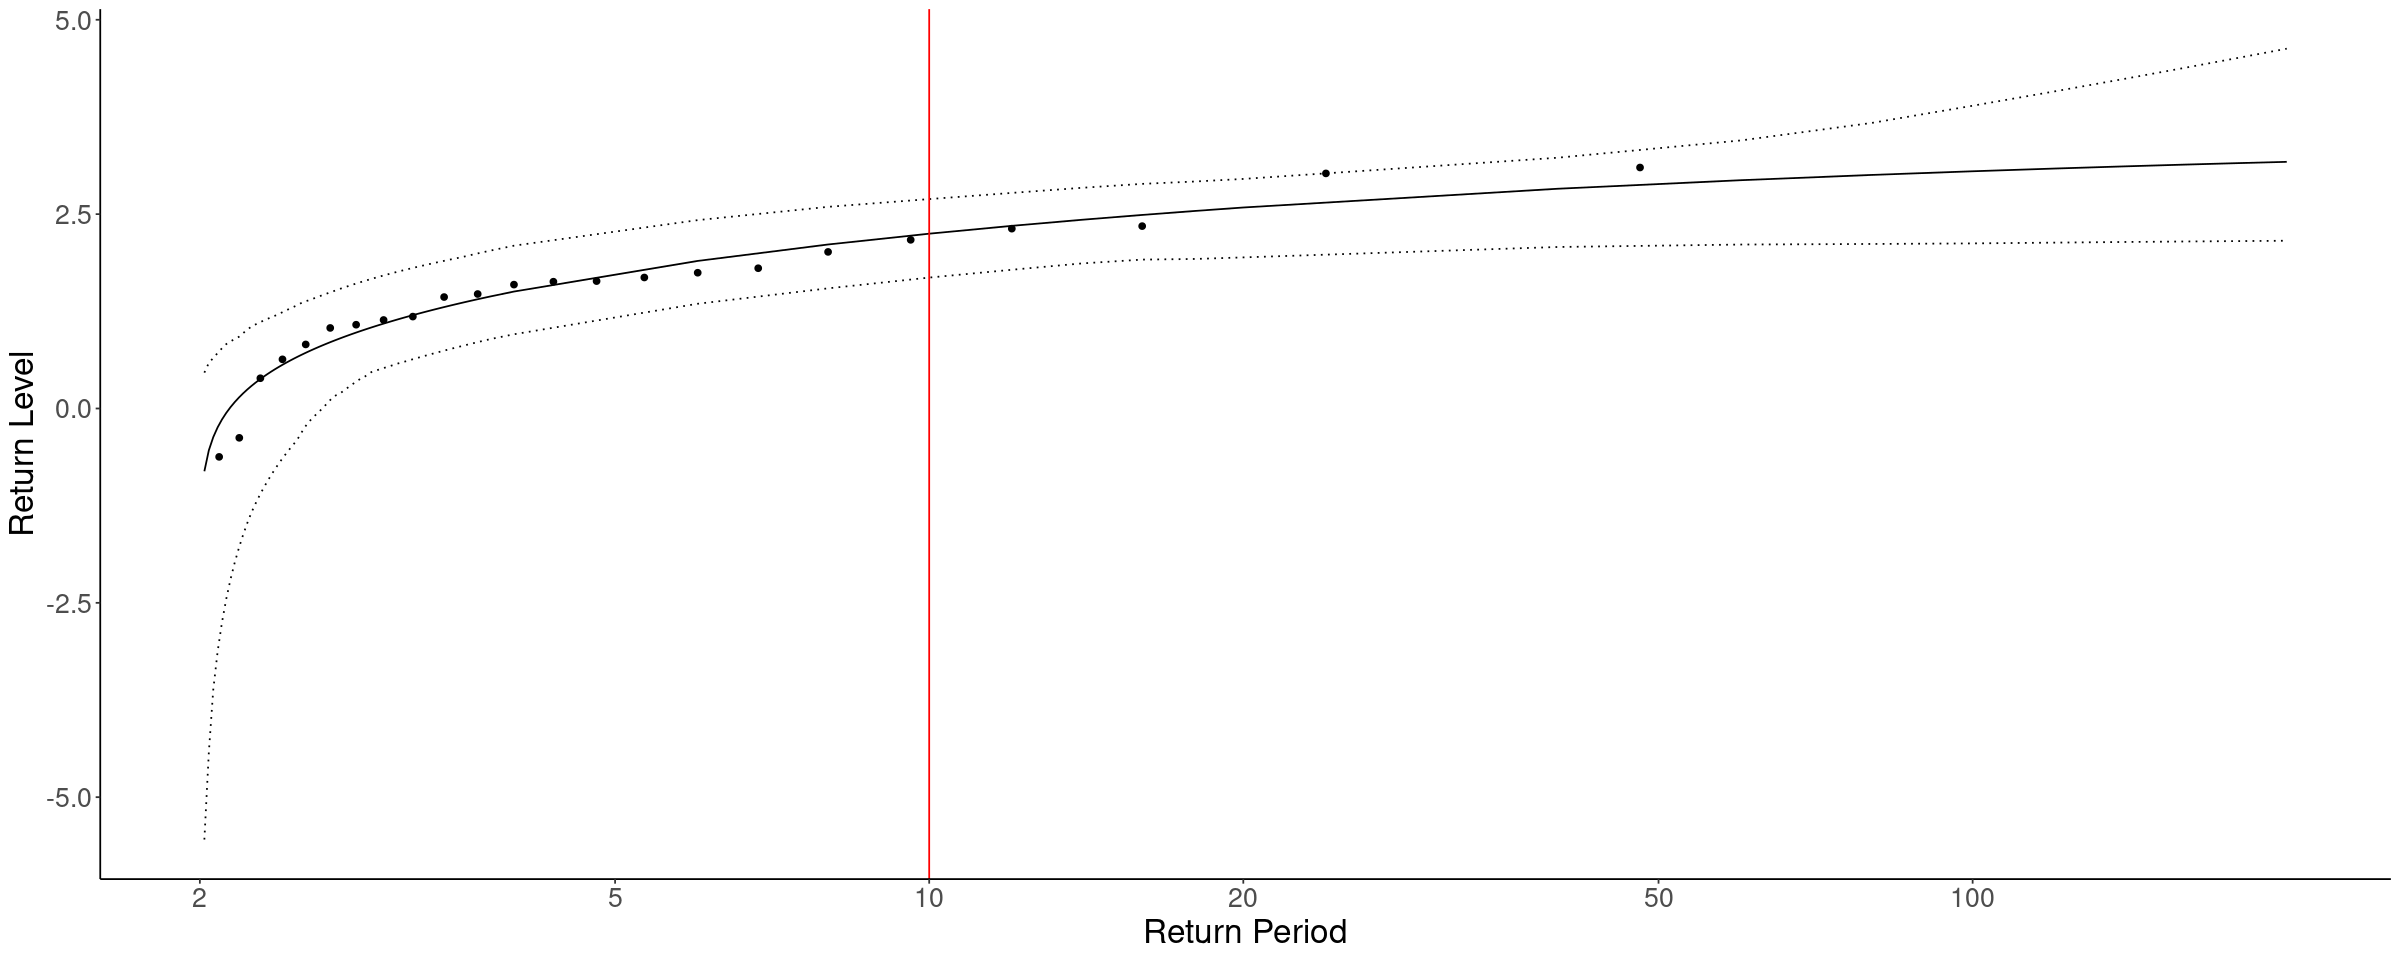

In [193]:
source("utils.r")
display_return_level_function(data = data_yearly_maxima_largerblock, parameters = gev_mle$param, max_trend = 0)

In [206]:
source("utils.r")
compute_return_level(return_period =10, parameters = gev_mle$param, n_obs = length(data_yearly_maxima_largerblock$Jahre), max_trend = max(data$trend))

[1] "GEV_MLE"


,Return_period,Return_level,Lower_CI_bound,Upper_CI_bound
,<dbl>,<dbl>,<dbl>,<dbl>
loc,100,433.7086,432.8913,434.4771
